In [1]:
# Instalação das dependências atualizadas
# Uninstall the current version of numpy
!pip uninstall -y numpy

# Install a different compatible version of numpy
!pip install numpy==1.26.0

# Install pymc and arviz again to ensure compatibility
!pip install pymc arviz

Found existing installation: numpy 1.26.0
Uninstalling numpy-1.26.0:
  Successfully uninstalled numpy-1.26.0
  Using cached numpy-1.26.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (58 kB)
Using cached numpy-1.26.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.9 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.0 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.0 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.0 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.0 which is incompatible.


In [2]:
# Bibliotecas
import pymc as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az
import pytensor.tensor as pt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("Versões das bibliotecas:")
print(f"PyMC: {pm.__version__}")
print(f"ArviZ: {az.__version__}")

Versões das bibliotecas:
PyMC: 5.25.1
ArviZ: 0.22.0


In [3]:
# 1. CARREGAR E PREPARAR OS DADOS
print("\n=== CARREGANDO DATASET CALIFORNIA HOUSING ===")
california = fetch_california_housing()
dt = pd.DataFrame(california.data, columns=california.feature_names)
dt['medv'] = california.target * 100000  # Converter para dólares

print(f"Shape do dataset: {dt.shape}")


=== CARREGANDO DATASET CALIFORNIA HOUSING ===
Shape do dataset: (20640, 9)


In [5]:
# Usar subset menor para garantir convergência
dt_sample = dt.sample(n=800, random_state=42)
print(f"Usando {len(dt_sample)} amostras para análise")

# Separar e normalizar dados
X = dt_sample.drop('medv', axis=1).values
y = dt_sample['medv'].values

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

y_mean = y.mean()
y_std = y.std()
y_scaled = (y - y_mean) / y_std

print(f"Dados normalizados - X: {X_scaled.shape}, y: {y_scaled.shape}")

Usando 800 amostras para análise
Dados normalizados - X: (800, 8), y: (800,)


In [6]:
# 2. MODELO MLP BAYESIANO CORRIGIDO
def run_safe_bayesian_mlp(X, y, H=5, samples=300, tune=150, chains=1):
    """
    Versão segura e simplificada do modelo MLP Bayesiano
    """

    N, p = X.shape
    print(f"\n🎯 Configurando modelo com {H} neurônios ocultos")

    try:
        with pm.Model() as model:
            # Priors conservadoras
            w1 = pm.Normal('w1', mu=0, sigma=0.05, shape=(p, H))
            b1 = pm.Normal('b1', mu=0, sigma=0.05, shape=H)
            w2 = pm.Normal('w2', mu=0, sigma=0.05, shape=H)
            b2 = pm.Normal('b2', mu=0, sigma=0.5)
            sigma = pm.HalfNormal('sigma', sigma=0.5)

            # Forward pass mais simples
            hidden_layer = pt.dot(X, w1) + b1
            activated_layer = pt.tanh(hidden_layer)
            output_layer = pt.dot(activated_layer, w2) + b2

            # Likelihood
            y_obs = pm.Normal('y_obs', mu=output_layer, sigma=sigma, observed=y)

            # Amostragem MCMC
            print("📊 Iniciando amostragem MCMC...")
            trace = pm.sample(
                draws=samples,
                tune=tune,
                chains=chains,
                target_accept=0.85,
                random_seed=42,
                progressbar=True,
                return_inferencedata=True
            )

        return model, trace, True

    except Exception as e:
        print(f"❌ Erro no modelo: {e}")
        return None, None, False

In [7]:
# 3. EXECUÇÃO PRINCIPAL CORRIGIDA
def main_safe():
    """
    Execução principal com tratamento de erros robusto
    """

    # Tentativa 1: Configuração mais simples
    print("=== TENTATIVA 1: Modelo simples ===")
    model, trace, success = run_safe_bayesian_mlp(X_scaled, y_scaled,
                                                 H=4, samples=200, tune=100, chains=1)

    if not success:
        # Tentativa 2: Ainda mais simples
        print("\n=== TENTATIVA 2: Modelo super simples ===")
        model, trace, success = run_safe_bayesian_mlp(X_scaled, y_scaled,
                                                     H=2, samples=150, tune=75, chains=1)

    if success:
        try:
            # Fazer previsões
            print("\n📈 Fazendo previsões...")
            with model:
                ppc = pm.sample_posterior_predictive(trace, random_seed=42)

            # Extrair previsões de forma compatível
            if hasattr(ppc, 'posterior_predictive'):
                y_pred_normalized = ppc.posterior_predictive['y_obs'].mean(axis=(0, 1)).values
            else:
                # Formato alternativo para versões mais antigas
                y_pred_normalized = ppc['y_obs'].mean(axis=0)

            y_pred = y_pred_normalized * y_std + y_mean

            # Métricas
            mse = mean_squared_error(y, y_pred)
            r2 = r2_score(y, y_pred)

            print(f"\n✅ MODELO TREINADO COM SUCESSO!")
            print(f"📊 MSE: {mse:.2f}")
            print(f"📊 RMSE: {np.sqrt(mse):.2f}")
            print(f"📊 R²: {r2:.4f}")

            # Gráficos básicos
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.scatter(y, y_pred, alpha=0.6, s=30)
            plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
            plt.xlabel('Observado')
            plt.ylabel('Predito')
            plt.title('Previsões vs Observados')
            plt.grid(True)

            plt.subplot(1, 3, 2)
            residuals = y - y_pred
            plt.scatter(y_pred, residuals, alpha=0.6, s=30)
            plt.axhline(y=0, color='r', linestyle='--')
            plt.xlabel('Predito')
            plt.ylabel('Resíduos')
            plt.title('Resíduos')
            plt.grid(True)

            # Diagnósticos de convergência simplificados
            plt.subplot(1, 3, 3)
            try:
                # Tentar plotar traços de forma segura
                az.plot_trace(trace, var_names=['sigma'])
                plt.title('Traços MCMC')
            except Exception as e:
                print(f"⚠️ Não foi possível plotar traços: {e}")
                plt.text(0.5, 0.5, 'Traços não disponíveis',
                        ha='center', va='center', transform=plt.gca().transAxes)
                plt.title('Diagnósticos')

            plt.tight_layout()
            plt.show()

            # Sumário simplificado
            print(f"\n📋 SUMÁRIO DOS PARÂMETROS:")
            try:
                summary = az.summary(trace)
                print(summary)
            except Exception as e:
                print(f"⚠️ Não foi possível gerar sumário: {e}")
                # Sumário manual básico
                print("Sigma:", trace.posterior['sigma'].mean().item())
                print("b2:", trace.posterior['b2'].mean().item())

        except Exception as e:
            print(f"❌ Erro nas previsões: {e}")

    else:
        print("\n💡 MODELO ALTERNATIVO: Regressão Linear Bayesiana")
        run_bayesian_linear_regression(X_scaled, y_scaled, y, y_mean, y_std)

In [8]:
# 4. MODELO ALTERNATIVO (Regressão Linear Bayesiana)
def run_bayesian_linear_regression(X, y_scaled, y_original, y_mean, y_std):
    """
    Modelo Bayesiano linear mais simples e robusto
    """

    try:
        with pm.Model() as linear_model:
            # Priors para regressão linear
            coefficients = pm.Normal('coefficients', mu=0, sigma=1, shape=X.shape[1])
            intercept = pm.Normal('intercept', mu=0, sigma=1)
            sigma = pm.HalfNormal('sigma', sigma=1)

            # Linear predictor
            mu = intercept + pt.dot(X, coefficients)

            # Likelihood
            y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y_scaled)

            # Amostragem
            trace_linear = pm.sample(200, tune=100, chains=1, random_seed=42,
                                   return_inferencedata=True, progressbar=True)

        # Previsões
        with linear_model:
            ppc_linear = pm.sample_posterior_predictive(trace_linear, random_seed=42)

        # Converter previsões
        if hasattr(ppc_linear, 'posterior_predictive'):
            y_pred_normalized = ppc_linear.posterior_predictive['y_obs'].mean(axis=(0, 1)).values
        else:
            y_pred_normalized = ppc_linear['y_obs'].mean(axis=0)

        y_pred = y_pred_normalized * y_std + y_mean

        # Métricas
        mse = mean_squared_error(y_original, y_pred)
        r2 = r2_score(y_original, y_pred)

        print(f"\n✅ REGRESSÃO LINEAR BAYESIANA TREINADA!")
        print(f"📊 MSE: {mse:.2f}")
        print(f"📊 R²: {r2:.4f}")

        # Gráfico simples
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.scatter(y_original, y_pred, alpha=0.6, s=30)
        plt.plot([y_original.min(), y_original.max()],
                [y_original.min(), y_original.max()], 'r--', lw=2)
        plt.xlabel('Observado')
        plt.ylabel('Predito')
        plt.title('Regressão Linear Bayesiana')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        az.plot_trace(trace_linear, var_names=['sigma', 'intercept'])
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Erro na regressão linear: {e}")

In [9]:
# 5. VERIFICAÇÃO INICIAL
def check_environment():
    """Verifica se o ambiente está configurado corretamente"""
    print("🔍 Verificando ambiente...")

    try:
        # Teste básico de funcionamento
        with pm.Model() as test_model:
            x = pm.Normal('x', mu=0, sigma=1)
            trace_test = pm.sample(10, tune=5, chains=1, random_seed=42, progressbar=False)
        print("✅ PyMC funcionando corretamente")
        return True
    except Exception as e:
        print(f"❌ Problema com PyMC: {e}")
        return False

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7d318b16b4c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


🔍 Verificando ambiente...


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7d318a13b7e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


✅ PyMC funcionando corretamente

🚀 Iniciando análise Bayesiana...
=== TENTATIVA 1: Modelo simples ===

🎯 Configurando modelo com 4 neurônios ocultos
📊 Iniciando amostragem MCMC...


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7d31889ff100>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/ctypes/__init__.py", line 379, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error
Exception ignored on calling ctypes callback function: <functio

Output()

Output()


📈 Fazendo previsões...



✅ MODELO TREINADO COM SUCESSO!
📊 MSE: 6377749070.26
📊 RMSE: 79860.81
📊 R²: 0.5319


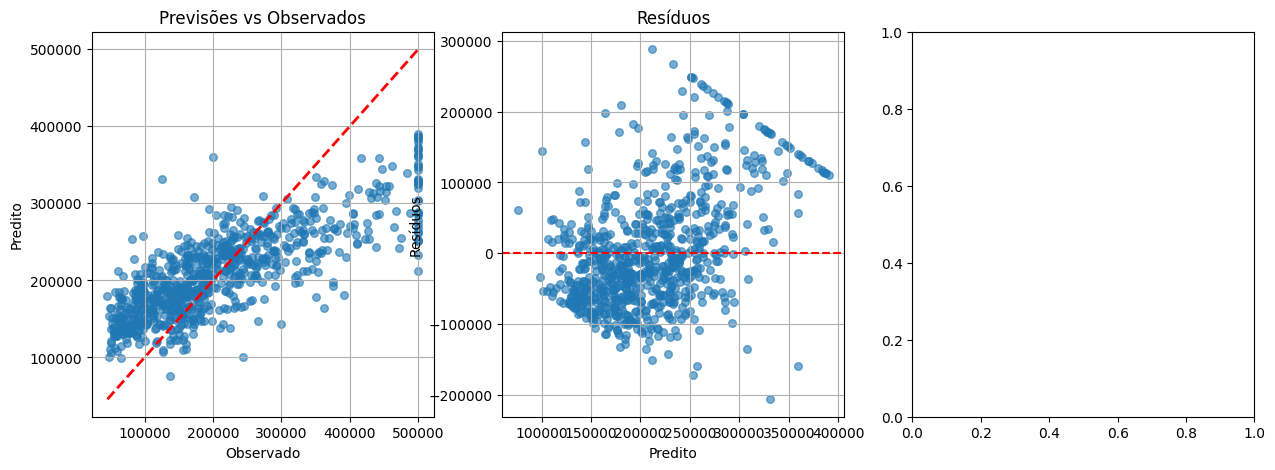

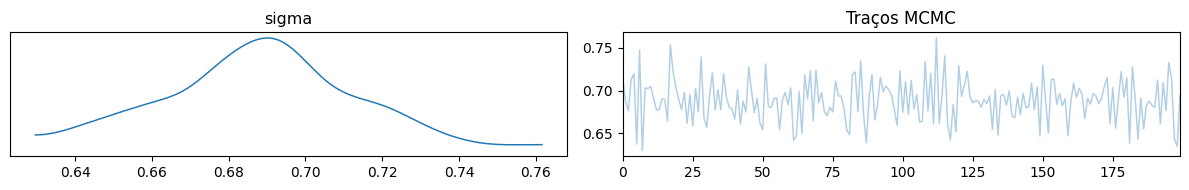


📋 SUMÁRIO DOS PARÂMETROS:


Shape validation failed: input_shape: (1, 200), minimum_shape: (chains=2, draws=4)


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b1[0]    -0.034  0.045  -0.110    0.058      0.003    0.002     305.0   
b1[1]    -0.034  0.046  -0.113    0.051      0.003    0.002     298.0   
b1[2]    -0.037  0.052  -0.125    0.069      0.003    0.004     380.0   
b1[3]    -0.041  0.043  -0.136    0.022      0.002    0.004     416.0   
b2        0.069  0.044  -0.010    0.148      0.003    0.004     245.0   
sigma     0.688  0.025   0.637    0.730      0.001    0.002     426.0   
w1[0, 0]  0.287  0.054   0.202    0.396      0.005    0.003     108.0   
w1[0, 1]  0.290  0.054   0.179    0.371      0.004    0.003     215.0   
w1[0, 2]  0.295  0.055   0.201    0.395      0.004    0.004     185.0   
w1[0, 3]  0.301  0.051   0.211    0.390      0.004    0.003     134.0   
w1[1, 0]  0.065  0.044  -0.030    0.134      0.003    0.004     304.0   
w1[1, 1]  0.070  0.044  -0.006    0.146      0.002    0.003     357.0   
w1[1, 2]  0.073  0.044   0.002    0.152      0.003 

In [10]:
# EXECUÇÃO PRINCIPAL
if __name__ == "__main__":
    if check_environment():
        print("\n🚀 Iniciando análise Bayesiana...")
        main_safe()
    else:
        print("\n💡 Soluções:")
        print("1. Execute: pip install --upgrade pymc arviz")
        print("2. Reinicie o kernel/runtime")
        print("3. Tente com menos dados e parâmetros mais simples")